In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.integrate import simps
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve, ShuffleSplit, cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from mne import Epochs, pick_types, events_from_annotations, EpochsArray, create_info, read_epochs
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch, psd_array_multitaper, stft
import seaborn as sns
from tqdm import tqdm

In [2]:
source_epochs = read_epochs('preprocessed_data/source_epochs-epo.fif', preload=True)
source_data = source_epochs.get_data()
source_data.shape

Reading /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/ml/preprocessed_data/source_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    4000.00 ms
        0 CTF compensation matrices available
Not setting metadata
4657 matching events found
No baseline correction applied
0 projection items activated


(4657, 4, 801)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/anushmutyala/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


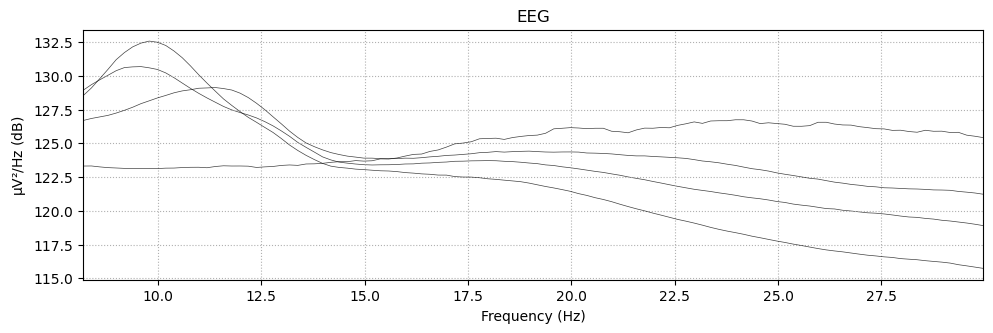

In [11]:
source_epochs.plot_psd(fmin=8, fmax=30, average=False, spatial_colors=False, n_jobs=1)

## S-FT CONFIG

- sim_time: Simulation time of each of the spiking stages involved. Each layer in the SNN contains two stages, silent and spiking -> increasing sim_time will increase the accuracy of the S-FT
- time_step: Time elapsed on each simulation step. NOTE: This value can only be 1 for simulations in Loihi
- mode: FT mode of operation. It can be "fft" or "dft" -> zero pad if FFT mode
- current_decay: Internal parameter for the current decay in Loihi. It should always be zero
- samples_per_chirp: Amount of samples contained on each chirp of the radar frame -> same as nsamples of source data
- chirps_per_frame: Amount of chirps that will be taken from the radar frame. With the default radar data, can take a maximum value of 4 -> not sure what this is... probably splits frame into chunks
- antennas: Number of antennas taken into consideration. With the default radar data, it can only be 1 -> can ignore
- nframes: Number of frames taken into consideration. With the default radar data, it can only be 1 -> use this to iterate over all batches of the dataset

In [3]:
config = {
    "snn_config": {
        "sim_time": 5000,
        "time_step": 1,
        "mode": "dft",
        "framework": "numpy",
        "current_decay": 0,
    },
    "data": {
        "samples_per_chirp": source_data.shape[-1], # samples per channel
        "chirps_per_frame": 1,
        "antennas": 1,
        "nframes": 1
    }
    
}

print(config["data"]["samples_per_chirp"])

801


In [4]:
import spikingFT.startup
# padded_source_data = np.pad(source_data, ((0,0), (0,0), (0, 1024 - source_data.shape[-1])))
sim_handler = spikingFT.startup.custom_run(source_data, config, autorun=False)

Intel NxSDK cannot be found. It will not be possible to run simulations with Loihi
Intel NxSDK cannot be found. It will not be possible to run simulations with Loihi


In [5]:
output = sim_handler.run(chirp_n=0) # chirp_n = source channel
real_spikes = output[:, 0] 
imag_spikes = output[:, 1]

In [6]:
nsamples = config["data"]["samples_per_chirp"]
# Remove offset bin and negative spectrum. They do not contain relevant information
sft_real = real_spikes[1:int(nsamples/2)]
sft_imag = imag_spikes[1:int(nsamples/2)]
# Normalize between -1 and 1
sft_max = np.max(np.abs(np.hstack([sft_real, sft_imag])))
sft_real = real_spikes / sft_max
sft_imag = imag_spikes / sft_max
sft_modulus = np.sqrt(sft_real**2 + sft_imag**2)
sft_modulus = np.log10(9*sft_modulus/sft_modulus.max()+1)


In [7]:
data = sim_handler.raw_data[0, 0, :]
norm_data = data - data.min()
norm_data /= norm_data.max()
norm_data = (norm_data-0.5) * 2
ft_np = np.fft.fft(norm_data) / (nsamples/2)
ft_real = ft_np.real[1:int(nsamples/2)]
ft_imag = ft_np.imag[1:int(nsamples/2)]
ft_modulus = np.abs(ft_np)[1:int(nsamples/2)]

# Evaluate Accuracy (S-FT vs. Numpy)
Using root-mean-square error. 

Text(0.5, 1.0, 'NumPy FFT')

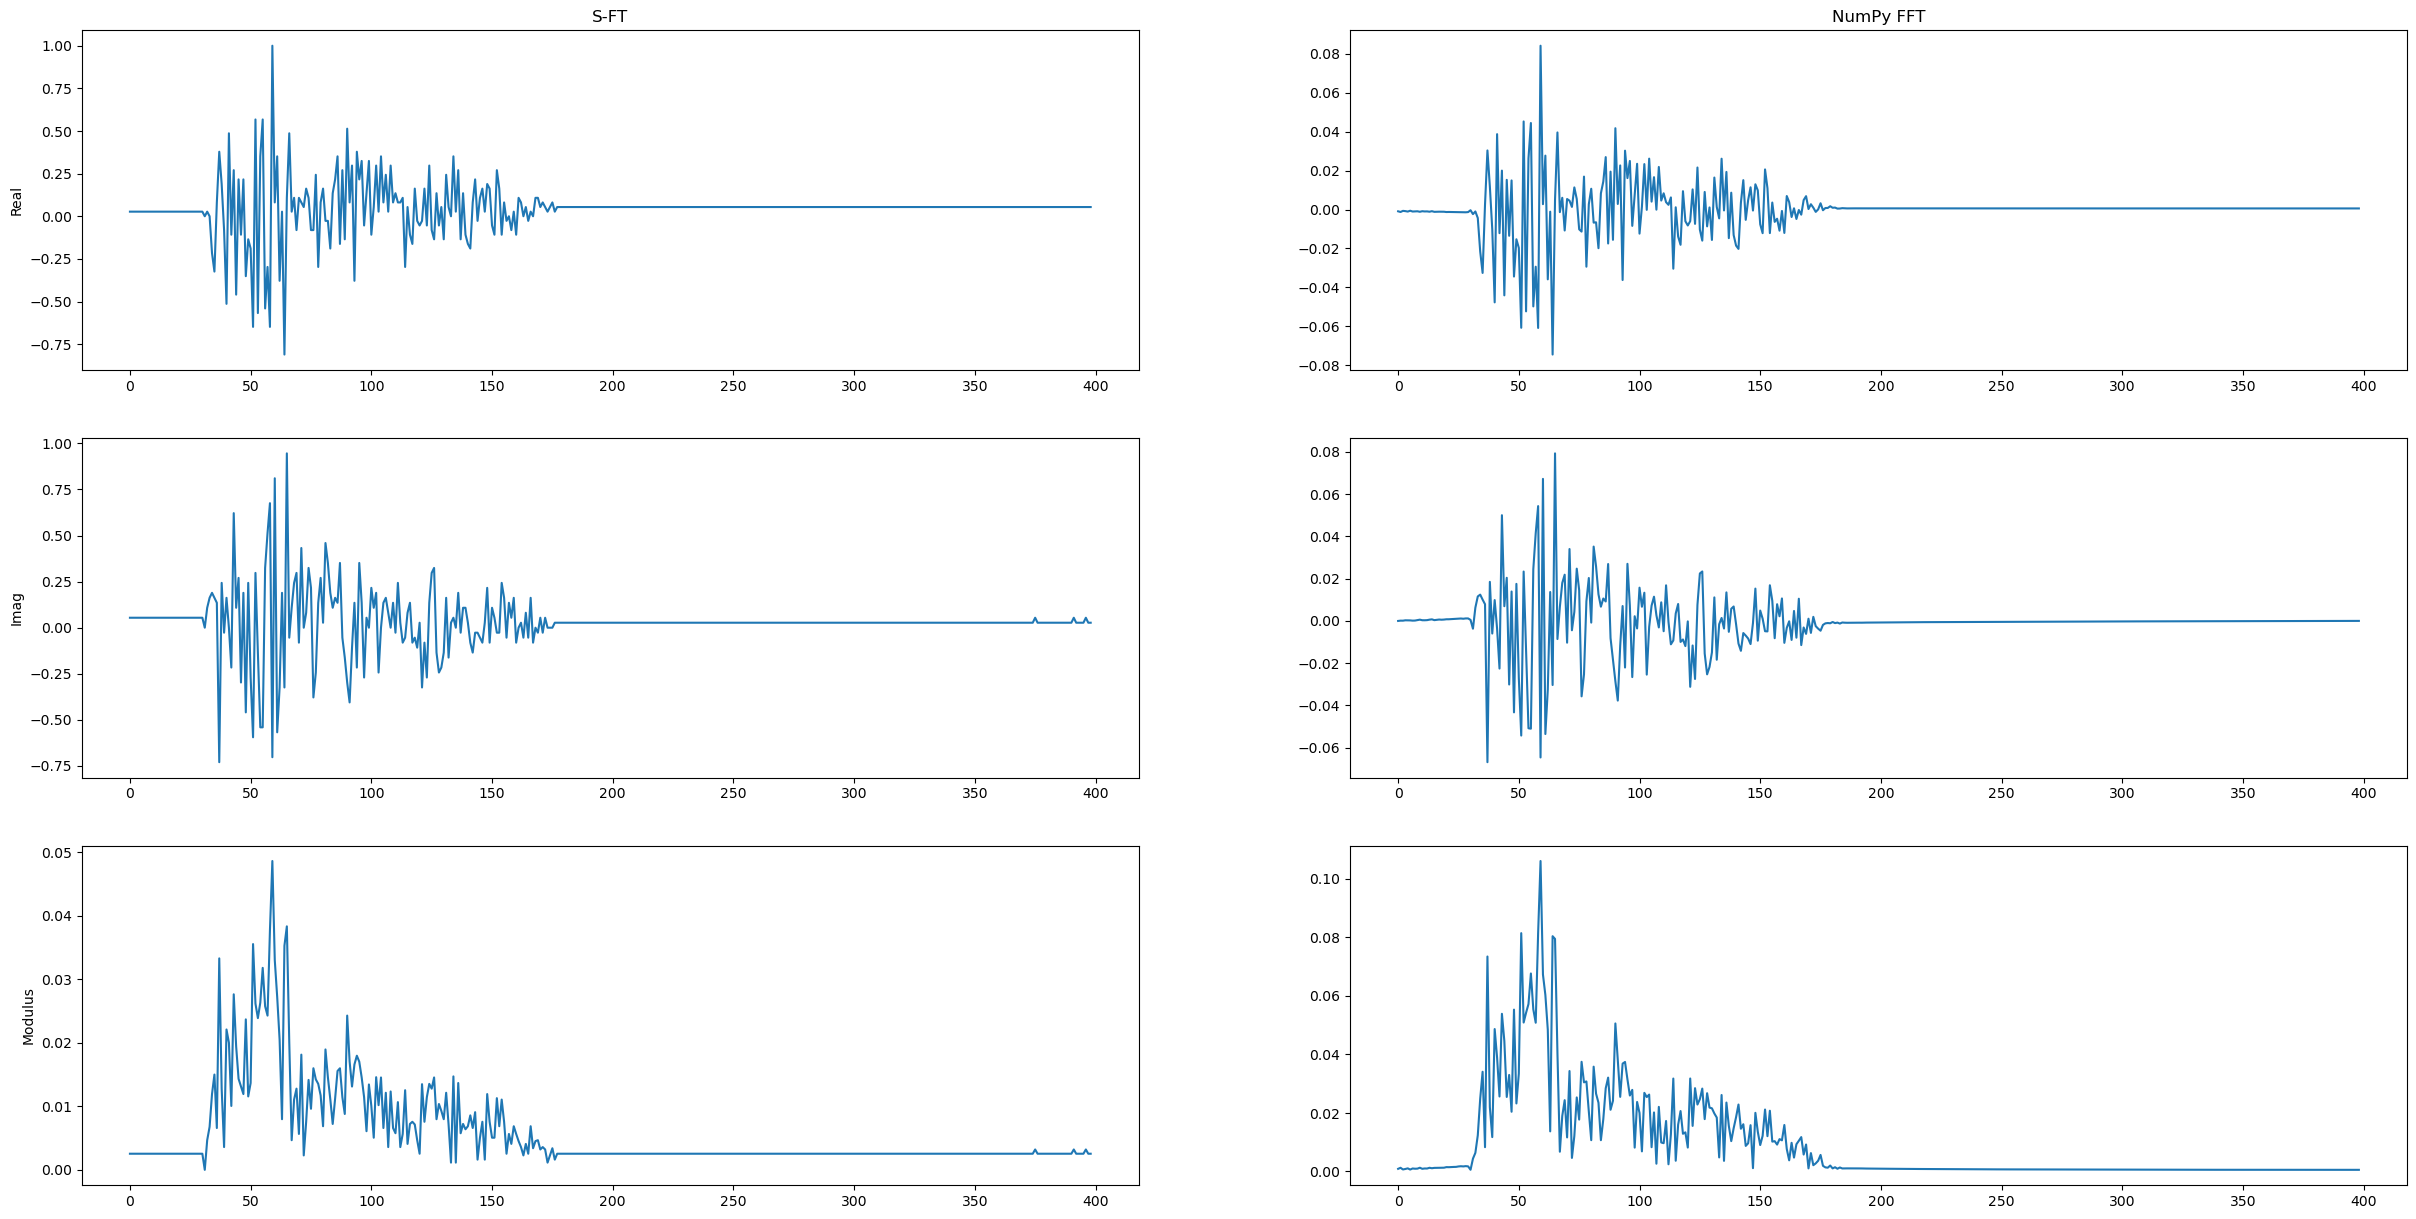

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (30, 15))
axes[0,0].plot(sft_real[1:nsamples//2])
axes[0,0].set_ylabel("Real")
axes[1,0].plot(sft_imag[1:nsamples//2])
axes[1,0].set_ylabel("Imag")
axes[2,0].plot(sft_modulus[1:nsamples//2])
axes[2,0].set_ylabel("Modulus")
axes[0,0].set_title("S-FT")

axes[0,1].plot(ft_real)
axes[1,1].plot(ft_imag)
axes[2,1].plot(ft_modulus)
axes[0,1].set_title("NumPy FFT")

In [9]:
# RMSE between S-FT and NumPy FFT

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ft_modulus, sft_modulus[1:nsamples//2])
rmse = np.sqrt(mse)
print("RMSE: ", rmse)


RMSE:  0.009938394206923653


# Neuronal Dynamic Plots

We will plot next the dynamics of the voltage and spike times for all the neurons involved in the simulation.

In the plot, it is very easy to observe a breaking point at half the simulation time. This indicates the change from the silent stage to the spiking stage. Throughout the second stage, the membrane voltage of the neurons is charged with a constant current that provokes a spike at a time proportional to the voltage at the end of the silent stage.

The scatter plot with the spiking times show two clusters of spikes. The first half belongs to neurons that represents the real values of the FT, whereas the second half belongs to neurons that represent imaginary values. The spikes at the half time of the second stage represent zero values, spikes that happen earlier represent positive values, and spikes that happen later represent negative values. 

In [10]:
!pip install ipympl

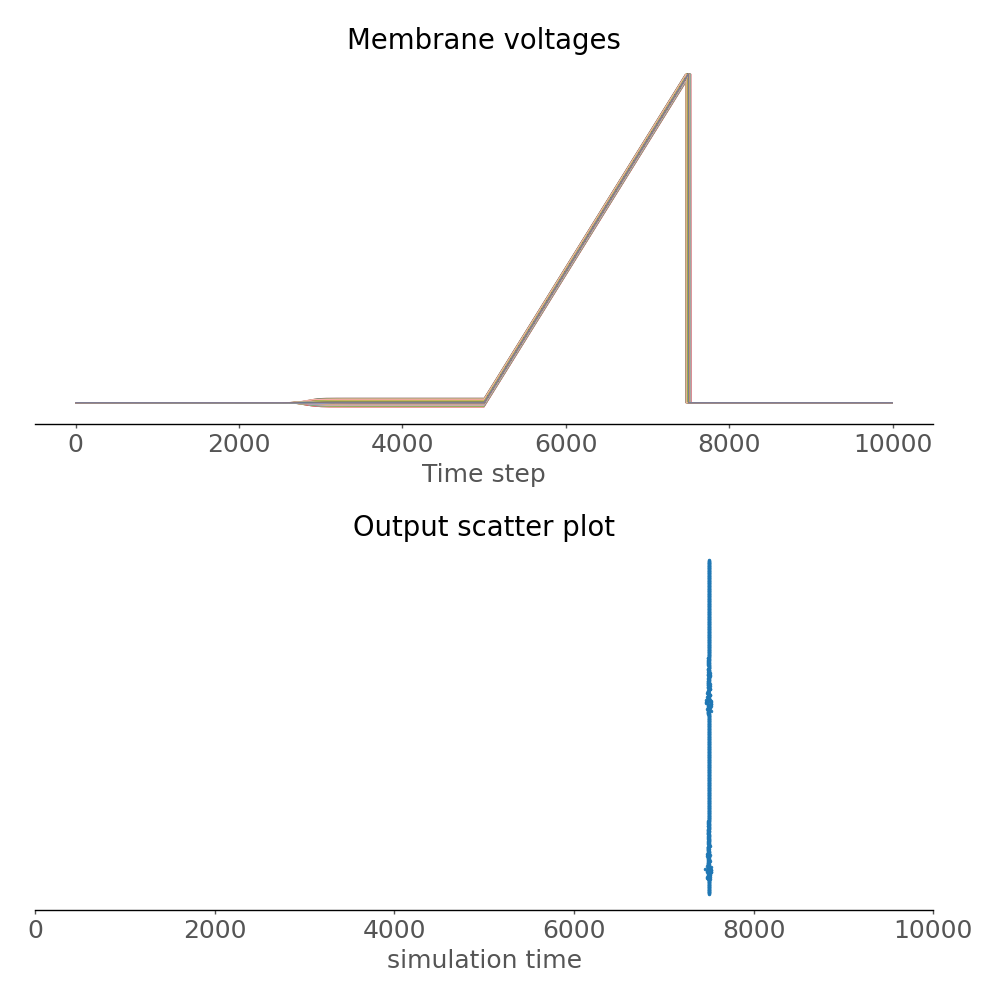

In [11]:
%matplotlib widget
import spikingFT.utils.plotter

sim_time = config["snn_config"]["sim_time"]
spikes = sim_handler.snn.spikes
voltage = sim_handler.snn.voltage
real = spikes[:, 0][1:int(nsamples/2)]
imag = spikes[:, 1][1:int(nsamples/2)]

# Plot S-FT result and reference result
kwargs = {}
kwargs["plot_names"] = ["voltages", "spikes"]
kwargs["data"] = [
voltage,
(real, imag, 2*sim_time),
]
sim_plotter = spikingFT.utils.plotter.SNNSimulationPlotter(**kwargs)
plt.rcParams['figure.figsize'] = [10,10]
fig = sim_plotter()

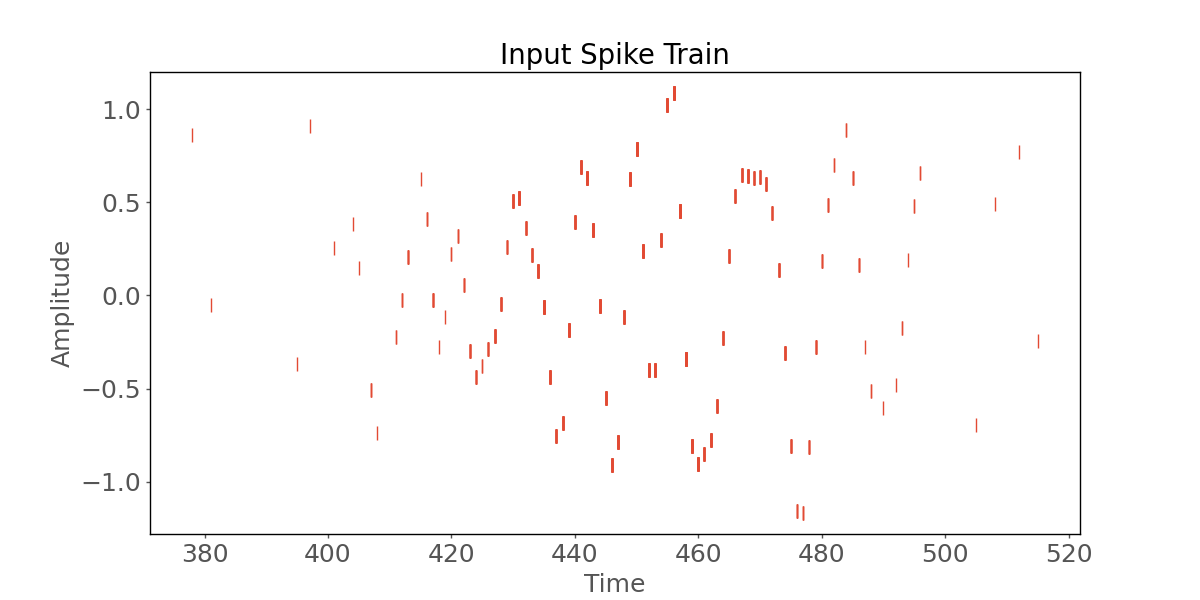

In [11]:
encoded_data = sim_handler.encoded_data[0, :]
source_data_single = source_data[0, 0, :]


# Calculate the indices of the source_data array corresponding to each spike time
spike_indices = (encoded_data / sim_time * len(source_data_single)).astype(int)

# Create arrays to store spike times and corresponding amplitudes
spike_times = []
spike_amplitudes = []

# Fill the spike_times and spike_amplitudes lists with non-zero amplitudes of the original data
for spike_idx in spike_indices:
    if spike_idx < len(source_data_single) and source_data_single[spike_idx] != 0:
        spike_times.append(spike_idx)
        spike_amplitudes.append(source_data_single[spike_idx])

# Convert lists to numpy arrays
spike_times = np.array(spike_times)
spike_amplitudes = np.array(spike_amplitudes)

# Plot the spike train
plt.figure(figsize=(12, 6))
plt.scatter(spike_times, spike_amplitudes, marker='|', s=100)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Input Spike Train")
plt.show()